In [4]:
import pandas
import numpy
import csv
import matplotlib.pyplot as plt


In [5]:
table = list([float(_) for _ in row] for row in csv.reader(open("ecg.csv", "r")))
normal = list(map(lambda row: row[:-1], filter(lambda row: row[-1] == 0, table)))
abnormal = list(map(lambda row: row[:-1], filter(lambda row: row[-1] == 1, table)))


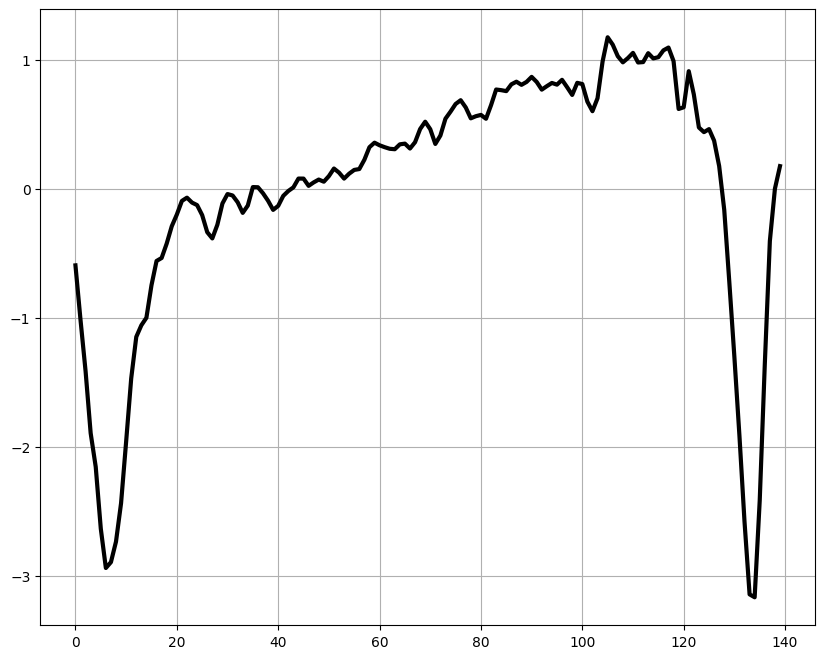

In [6]:
plt.figure(figsize=(10,8))
plt.grid()
plt.plot(normal[10],color='black',linewidth=3.0)

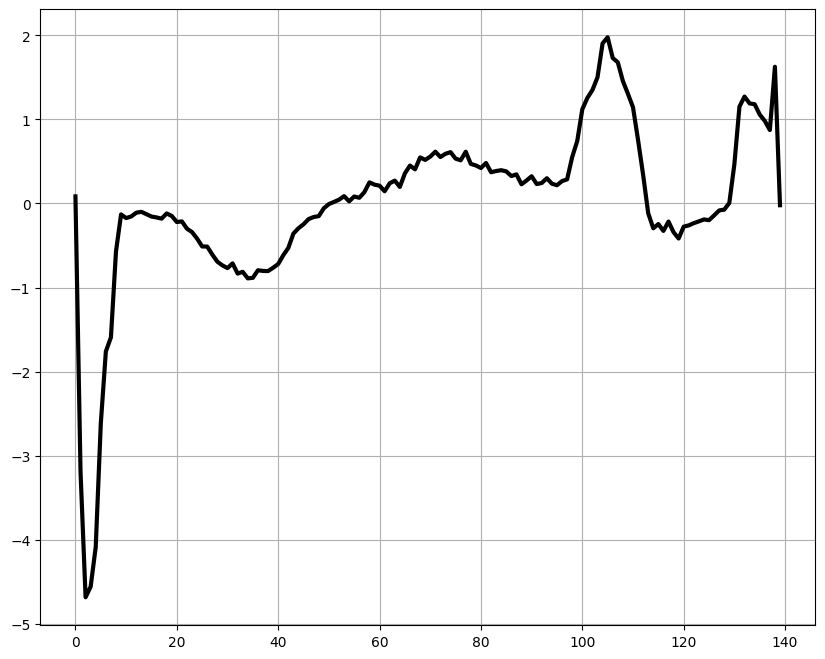

In [7]:
plt.figure(figsize=(10,8))
plt.grid()
plt.plot(abnormal[10],color='black',linewidth=3.0)

In [8]:
# plt.figure(figsize=(10,8))


# # Data
# plt.plot(normal_test_data[i], 'black',linewidth=2)

# # C1
# plt.plot(decoded_imgs[i], 'red',linewidth=2)
# plt.fill_between(numpy.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
# plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show()

C:\Users\Enes Akyuz\AppData\Local\Temp\ipykernel_1392\2669600937.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  original = np.array(original, dtype=np.float)
C:\Users\Enes Akyuz\AppData\Local\Temp\ipykernel_1392\2669600937.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_arr = np.linspace(0, len(original) - 1, num=targetLe

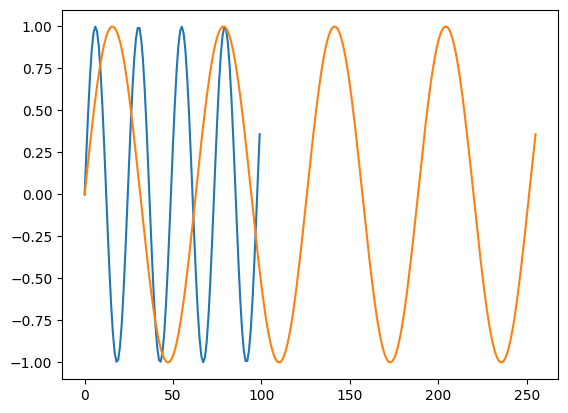

In [9]:
# import torch
# import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
# from scipy.signal import resample
# from scipy.interpolate import interp1d


# class Block(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Block, self).__init__()
#         self.hidden_size = hidden_size
#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.c2o = nn.Linear(input_size + hidden_size, output_size)

#     def forward(self, x, hidden_state):
#         combined = torch.cat((x, hidden_state), 1)
#         hidden = torch.sigmoid(self.i2h(combined))
#         output = self.c2o(combined)
#         return output, hidden

#     def init_hidden(self):
#         return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))


def ResampleLinear1D(original, targetLen):
    original = np.array(original, dtype=np.float)
    index_arr = np.linspace(0, len(original) - 1, num=targetLen, dtype=np.float)
    index_floor = np.array(index_arr, dtype=np.int)  # Round down
    index_ceil = index_floor + 1
    index_rem = index_arr - index_floor  # Remain
    val1 = original[index_floor]
    val2 = original[index_ceil % len(original)]
    interp = val1 * (1.0 - index_rem) + val2 * index_rem
    assert len(interp) == targetLen
    return interp


original = np.sin(np.arange(256) / 10.0)
targetLen = 100

# Method 1: Use scipy interp1d (linear interpolation)
# This is the simplest conceptually as it just uses linear interpolation. Scipy
# also offers a range of other interpolation methods.
# f = interp1d(np.arange(256), original, "linear")
# plt.plot(np.apply_along_axis(f, 0, np.linspace(0, 255, num=targetLen)))

# Method 2: Use numpy to do linear interpolation
# If you don't have scipy, you can do it in numpy with the above function
plt.plot(ResampleLinear1D(original, targetLen))
plt.plot(original)

# # Method 3: Use scipy's resample
# # Converts the signal to frequency space (Fourier method), then back. This
# # works efficiently on periodic functions but poorly on non-periodic functions.
# plt.plot(resample(original, targetLen))

plt.show()


C:\Users\Enes Akyuz\AppData\Local\Temp\ipykernel_1392\4275006960.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  original = np.array(original, dtype=np.float)
C:\Users\Enes Akyuz\AppData\Local\Temp\ipykernel_1392\4275006960.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_arr = np.linspace(0, len(original) - 1, num=targetLe

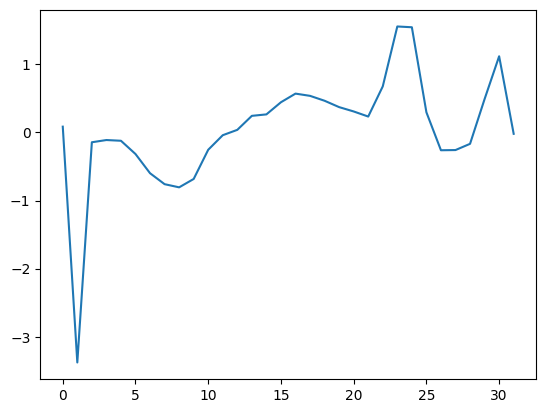

In [23]:
# import torch
# import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
# from scipy.signal import resample
# from scipy.interpolate import interp1d


# class Block(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Block, self).__init__()
#         self.hidden_size = hidden_size
#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.c2o = nn.Linear(input_size + hidden_size, output_size)

#     def forward(self, x, hidden_state):
#         combined = torch.cat((x, hidden_state), 1)
#         hidden = torch.sigmoid(self.i2h(combined))
#         output = self.c2o(combined)
#         return output, hidden

#     def init_hidden(self):
#         return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))


def ResampleLinear1D(original, targetLen):
    original = np.array(original, dtype=np.float)
    index_arr = np.linspace(0, len(original) - 1, num=targetLen, dtype=np.float)
    index_floor = np.array(index_arr, dtype=np.int)  # Round down
    index_ceil = index_floor + 1
    index_rem = index_arr - index_floor  # Remain
    val1 = original[index_floor]
    val2 = original[index_ceil % len(original)]
    interp = val1 * (1.0 - index_rem) + val2 * index_rem
    assert len(interp) == targetLen
    return interp


#original = np.sin(np.arange(256) / 10.0)
targetLen = 32

# Method 1: Use scipy interp1d (linear interpolation)
# This is the simplest conceptually as it just uses linear interpolation. Scipy
# also offers a range of other interpolation methods.
#f = interp1d(np.arange(256), original, "linear")
#plt.plot(np.apply_along_axis(f, 0, np.linspace(0, 255, num=targetLen)))

# Method 2: Use numpy to do linear interpolation
# If you don't have scipy, you can do it in numpy with the above function
plt.plot(ResampleLinear1D(abnormal[10], targetLen))
#plt.plot(abnormal[10])

# # Method 3: Use scipy's resample
# # Converts the signal to frequency space (Fourier method), then back. This
# # works efficiently on periodic functions but poorly on non-periodic functions.
# plt.plot(resample(original, targetLen))

plt.show()
